In [54]:
import numpy as np_ # Original numpy 
import scipy as sp

import random

# Plot
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# qnode device
dev = qml.device('default.mixed', wires = 1)

# Hamiltonian setup 
coeffs = [-0.5]
obs = [qml.PauliZ(0)]

hamiltonian = qml.Hamiltonian(coeffs, obs)  # Define Hamiltonian

In [55]:
# Global paras 
Tau_global = 5e-2   # Dephase tau
# Tau_global = 1e-100   # Dephase tau
Paras_global, Phi_global, Gamma_ps  = np.zeros(2), 0, 0

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""

    Calculate_Gamma = 1 - np.exp(-2 * tau)
    
    return Calculate_Gamma    # Return gamma

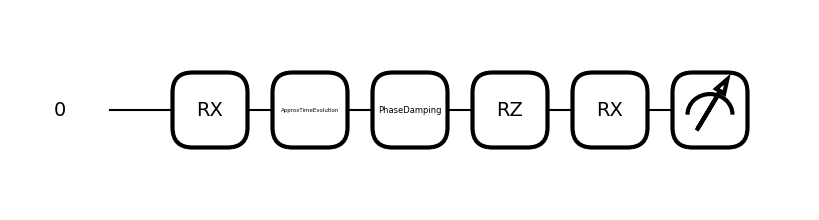

In [56]:
@qml.qnode(dev)
def circuit(paras):
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Set dephase factor 
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = paras[0], paras[1]

    qml.RX(np.pi/2, wires = 0)
    # qml.Hadamard(wires=0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)


@qml.qnode(dev)
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = 0)
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    
    Numerator = K @ density_matrix @ K.conj().T
    Denominator = np.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

paras_plot = 1,1
fig, ax = qml.draw_mpl(circuit)(paras_plot)

In [57]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [58]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    """ Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        Sweep_Data (numpy_array): Range of data sweeps.
        paras (numpy_array): Array of 3 parameters for the qnode.
        gamma_ps_select (int): The Gamma value for post-selection.
        Iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array
    """
    
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # INDEX CONSTANT
    CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Before optimization; CFI data
    for Phi_Index in range(len(PHI)):
        Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
        for Paras_Index_Array in range(len(paras)):
            Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][PARAS_INDEX + Paras_Index_Array] = paras[Paras_Index_Array]
        
        
    # Optimize begin
    for Layer_Index in range(1, Iterations + 1):
        for Phi_Index in range(len(PHI)):
            # Load previous paras
            Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
            # Set Phi(Currently sweeping)
            Phi_global = Data[Layer_Index][Phi_Index][0]
            
            # Constraints(gamma = 0.99..) 
            tau_upper = 18
            Constraints = [(-float('inf'), float('inf'))] * 2 
            
            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(Cost_function, Paras_Temporary, method = 'L-BFGS-B', bounds = Constraints)
            Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
            # Store data in array
            for Paras_Index_Array in range(len(Paras_Temporary)):
                Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

In [59]:
a = np.zeros(5)
b = np.array([1,2,3,4,5])

a[:] = b[:]

a

tensor([1., 2., 3., 4., 5.], requires_grad=True)

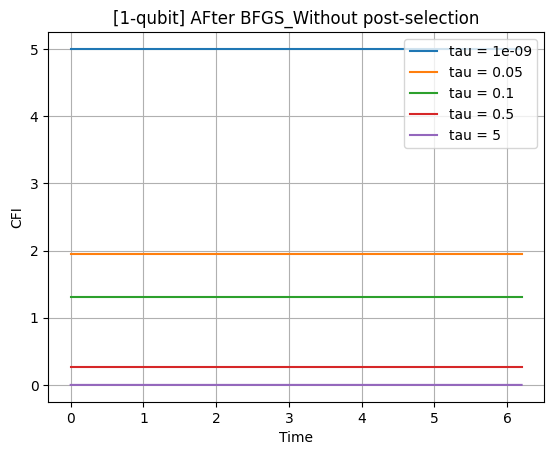

In [60]:
tau_plot = 1e-09, 5e-2, 1e-1, 5e-1, 5
Sweep_data = np_.array([1e-4, np.pi * 2 + 1e-4, 1e-1])

Sweep_data_arange = np_.arange(Sweep_data[0], Sweep_data[1], Sweep_data[2])

Para_store = np.zeros((len(tau_plot), len(Sweep_data_arange), 2))

for i in range(len(tau_plot)):
    Tau_global = tau_plot[i]
    
    Paras_init = np.zeros(2)
    Paras_init[:2] = random.uniform(3, 6)

    Gamma_ps_preset = 0.8
    Set_Iterations = 1

    Optimized_Result = BFGS(Sweep_data, Paras_init, Gamma_ps_preset, Set_Iterations)
    
    Para_store[i][:, 0] = Optimized_Result[1][:,2]
    Para_store[i][:, 1] = Optimized_Result[1][:,3]
    
    # plt.plot(Sweep_data_arange, Optimized_Result[0][:, 1], label = f'Before_tau = {tau_plot[i]}')
    plt.plot(Sweep_data_arange, Optimized_Result[1][:, 1], label = f'tau = {tau_plot[i]}')
    plt.title(f'[1-qubit] AFter BFGS_Without post-selection')
    
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

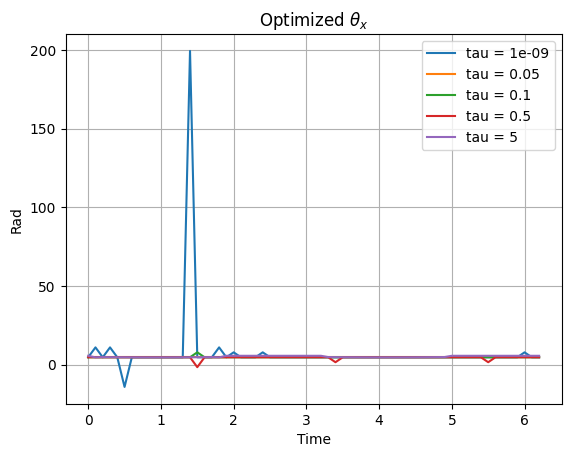

In [61]:
for i in range(len(tau_plot)):
    plt.plot(Sweep_data_arange, Para_store[i][:, 0], label = f'tau = {tau_plot[i]}')
plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

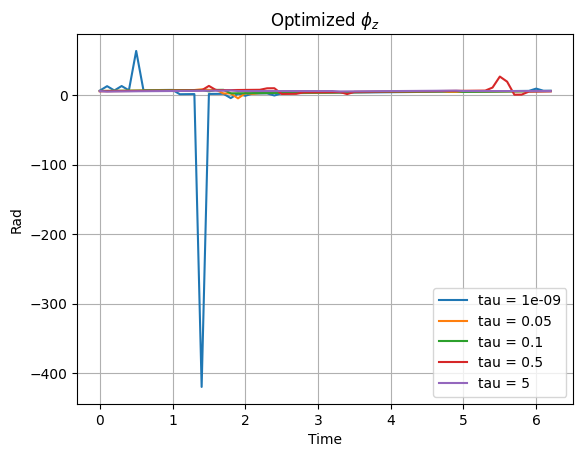

In [62]:
for i in range(len(tau_plot)):
    plt.plot(Sweep_data_arange, Para_store[i][:, 1], label = f'tau = {tau_plot[i]}')
plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

In [63]:
Para_store[0][:,0]

tensor([  4.71238914,  10.99557364,   4.71238882,  10.99557431,
          4.71238909, -14.13716677,   4.712389  ,   4.71238898,
          4.71238897,   4.71238898,   4.7123894 ,   4.71238895,
          4.71238883,   4.71238935, 199.49113349,   4.71238948,
          4.7123889 ,   4.71238898,  10.99557429,   4.71238881,
          7.85398163,   4.71238889,   4.71238903,   4.71238897,
          7.85398168,   4.71238883,   4.71238897,   4.71238881,
          4.71238892,   4.71238937,   4.71238898,   4.71238908,
          4.71238904,   4.71238936,   4.71238918,   4.71238862,
          4.71238885,   4.712389  ,   4.71238913,   4.71238869,
          4.71238945,   4.71238921,   4.7123889 ,   4.71238856,
          4.71238912,   4.71238942,   4.71238902,   4.71238946,
          4.71238857,   4.71238899,   4.71238905,   4.71238851,
          4.71238856,   4.71238855,   4.71238896,   4.71238887,
          4.71238898,   4.71238902,   4.71238912,   4.71238899,
          7.85398163,   4.71238888,   4.

In [64]:
Para_store[0][:,1]

tensor([   6.27764918,   12.67207088,    6.47761204,   12.860854  ,
           6.6889145 ,   63.32631395,    6.87766079,    6.97768622,
           7.07766559,    7.18890587,    7.27765257,    1.09447591,
           1.19448152,    1.30571282, -419.56769263,    1.50570203,
           1.59445628,    1.69449343,   -4.4774879 ,    1.89444269,
          -1.13592017,    2.09449501,    2.20573116,    2.30566669,
          -0.74711251,    2.50572341,    2.60571702,    2.70571579,
           2.80573902,    2.90569151,    3.00570357,    3.10572583,
           3.2057299 ,    3.30571204,    3.40573471,    3.49446191,
           3.6057384 ,    3.69448841,    3.79448857,    3.89446901,
           3.9945153 ,    4.09447034,    4.19447312,    4.29449976,
           4.40570816,    4.50570998,    4.59447175,    4.70574346,
           4.79443225,    4.89448972,    4.99447903,    5.09444026,
           5.19447688,    5.29449298,    5.39447881,    5.49446363,
           5.59447817,    5.6944627 ,    5.80571

In [65]:
Optimized_Result

array([[[1.00000000e-04, 2.31078219e-06, 5.65794629e+00, 5.65794629e+00],
        [1.00100000e-01, 2.31078219e-06, 5.65794629e+00, 5.65794629e+00],
        [2.00100000e-01, 2.31078219e-06, 5.65794629e+00, 5.65794629e+00],
        [3.00100000e-01, 2.31078219e-06, 5.65794629e+00, 5.65794629e+00],
        [4.00100000e-01, 2.31078219e-06, 5.65794629e+00, 5.65794629e+00],
        [5.00100000e-01, 2.31078219e-06, 5.65794629e+00, 5.65794629e+00],
        [6.00100000e-01, 2.31078219e-06, 5.65794629e+00, 5.65794629e+00],
        [7.00100000e-01, 2.31078219e-06, 5.65794629e+00, 5.65794629e+00],
        [8.00100000e-01, 2.31078219e-06, 5.65794629e+00, 5.65794629e+00],
        [9.00100000e-01, 2.31078219e-06, 5.65794629e+00, 5.65794629e+00],
        [1.00010000e+00, 2.31078219e-06, 5.65794629e+00, 5.65794629e+00],
        [1.10010000e+00, 2.31078219e-06, 5.65794629e+00, 5.65794629e+00],
        [1.20010000e+00, 2.31078219e-06, 5.65794629e+00, 5.65794629e+00],
        [1.30010000e+00, 2.31078219e-0